<a href="https://colab.research.google.com/github/ChrisHarvey21/HABs/blob/main/HABs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#HABs Model
#creating a model to determine HAB severity based on input variables

In [2]:
%%capture
!pip install geopandas
!pip install libpysal

In [3]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from numpy import mean
from numpy import std
from numpy import absolute
from libpysal.weights.contiguity import Queen
import libpysal
from statsmodels.api import OLS
sns.set_style('white')

In [ ]:
#attach to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#load in dataset
#import required function:
import urllib.request

url = 'https://raw.githubusercontent.com/ChrisHarvey21/HABs/main/habs.csv?token=GHSAT0AAAAAABZDDLJKOAQ25ZIOQNZGJFAGY3AFJKQ'

df1 = pd.read_csv(url)


In [ ]:
#View Dataset
df1.head()

In [ ]:
#Create subset of habs called mylist
my_list = ["date", "severity", "precip", "precip_1_day" , "pecip_2_day", "3_day_sum", "max_temp", "mean_temp"]      

In [ ]:
#check to make sure all your columns are there:
df1[my_list].head(10)

In [ ]:
#Seaborn.pairplot to plot a scatterplot matrix
sns.pairplot(df1[my_list])

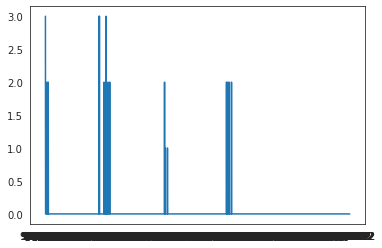

In [59]:
#look at timeseries of algal seveirty versus time of year
plt.plot(df1['date'],df1['severity'])
plt.show()

In [ ]:
#Do VIF, if any are greater than 10 we have to either throw out predictor variables that arent important or add on bias reducers
